# Processing und Downsampling

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import sklearn.cluster as sk
from PIL import Image
from torchvision import transforms

In [2]:
def displayimage(imgarr, r=1, c=3):
    plt.figure(figsize=(18,32))
    count = 1
    for i in range(1,r+1):
        for j in range(1,c+1):
            plt.subplot(r,c,count)
            plt.imshow(imgarr[count-1])
            count += 1
    plt.show() 

In [18]:
img = cv2.cvtColor(cv2.imread('images/nur.jpg'), cv2.COLOR_BGR2RGB)
croptrans = transforms.CenterCrop((100,100))
imcrop = croptrans(Image.fromarray(img))
blur = cv2.blur(img,(5,5))
gblur = cv2.GaussianBlur(img,(9,9),15)
median = cv2.medianBlur(img,9)
bilin = cv2.bilateralFilter(img,9,75,75)

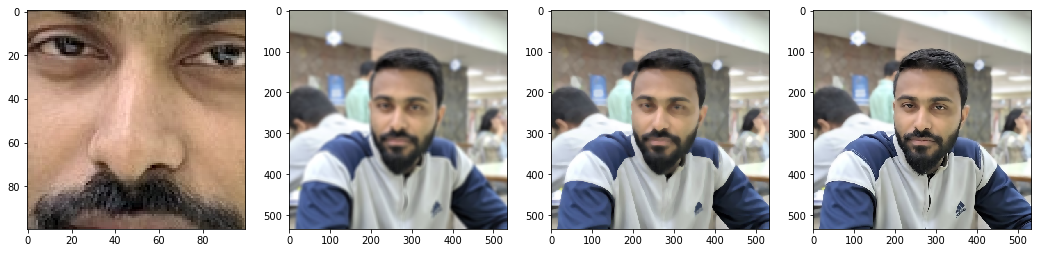

In [19]:
imgarray = []
imgarray.append(imcrop)
imgarray.append(gblur)
imgarray.append(median)
imgarray.append(bilin)
displayimage(imgarray,r=1,c=4)

(<matplotlib.axes._subplots.AxesSubplot at 0x2b040f20ef0>,
 Text(0.5, 1.0, 'Quantized'))

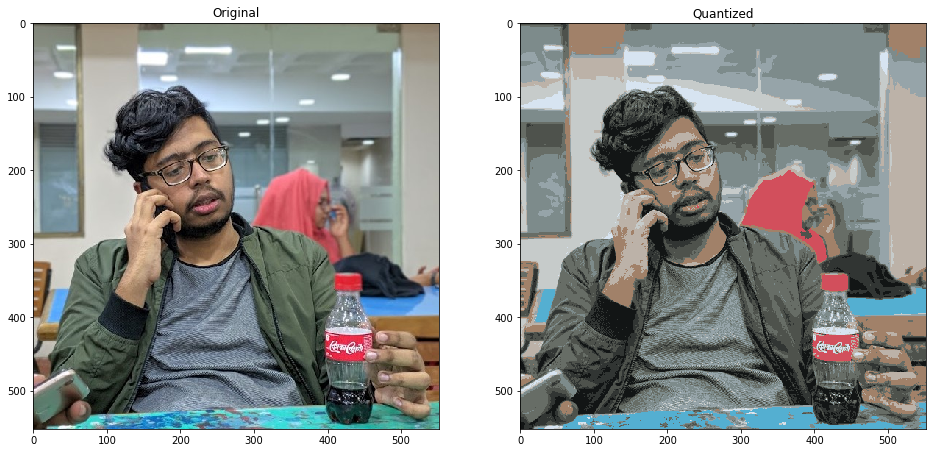

In [5]:
original = cv2.cvtColor(cv2.imread('images/abr.jpg'), cv2.COLOR_BGR2RGB)
n_colors = 12

arr = original.reshape((-1, 3))
kmeans = sk.MiniBatchKMeans(n_clusters=n_colors, random_state=42).fit(arr)
labels = kmeans.labels_
centers = kmeans.0
less_colors = centers[labels].reshape(original.shape).astype('uint8')

plt.figure(figsize=(16,8))
plt.subplot(121),plt.imshow(original),plt.title('Original')
plt.subplot(122),plt.imshow(less_colors),plt.title('Quantized')

In [6]:
blur = cv2.blur(less_colors,(5,5))
gblur = cv2.GaussianBlur(less_colors,(7,7),0)
median = cv2.medianBlur(less_colors,5)
# bilin = cv2.bilateralFilter(less_colors,9,75,75)
downed = cv2.resize(median, dsize=(96, 96), interpolation=cv2.INTER_CUBIC)

<Figure size 1296x1152 with 0 Axes>

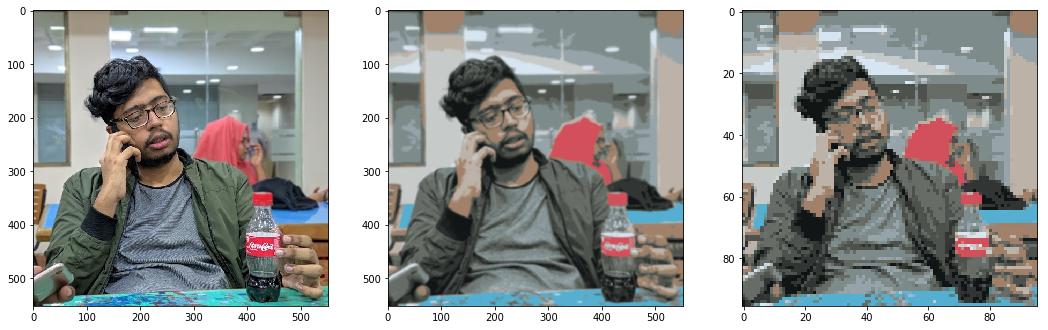

In [7]:
plt.figure(figsize=(18,16))
imgarray = []
imgarray.append(original)
imgarray.append(gblur)
imgarray.append(downed)
displayimage(imgarray,r=1,c=3)

(<matplotlib.axes._subplots.AxesSubplot at 0x1c9f848b748>,
 Text(0.5, 1.0, 'Thresholded'))

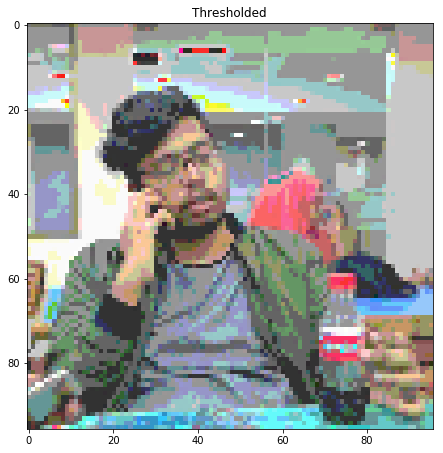

In [31]:
import math

image = cv2.cvtColor(cv2.imread('images/abr.jpg'), cv2.COLOR_BGR2RGB)

def roundup(x,div=10):
    return int(math.ceil(x / div)) * div

h = image.shape[0]
w = image.shape[1]
c = image.shape[2]
for y in range(0, h):
    for x in range(0, w):
        for z in range(0, c):
            image[y, x, z] = roundup(image[y, x, z],50)
            
median = cv2.medianBlur(image,5)
image = cv2.resize(median, dsize=(96, 96), interpolation=cv2.INTER_CUBIC)

plt.figure(figsize=(16,8))
plt.subplot(122),plt.imshow(image),plt.title('Thresholded')

# DataLoading

In [1]:
import numpy as np
import pandas as pd
import gc

import warnings
warnings.filterwarnings('ignore')

import os
import glob
import os.path as osp

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils import data as D
from PIL import Image

In [3]:
class Picsle8DS(D.Dataset):
    
    def __init__(self, root):
        """ Intialize the dataset """
        self.filearray = []
        self.labels = []
        self.root = root
        self.transform = transforms.ToTensor()
        filenames = glob.glob(osp.join(self.root+'Pixelart/', '*.jpg'))
        for fn in filenames:
            self.filearray.append(fn)
            self.labels.append(1)
        filenames = glob.glob(osp.join(self.root+'Realpix/', '*.jpg'))
        for fn in filenames:
            self.filearray.append(fn)
            self.labels.append(0)
        self.len = len(self.filearray)
        
    def __getitem__(self, index):
        """ Get a sample from the dataset """
        image = Image.open(self.filearray[index])
        if image.size[0] != image.size[1]:
            sqrsize = min(image.size)
            croptrans = transforms.CenterCrop((sqrsize,sqrsize))
            image = croptrans(image)
        nimage = image.resize((192, 192), Image.NEAREST)
        nimage = nimage.convert('RGB')
        label = self.labels[index]
        return self.transform(nimage), label

    def __len__(self):
        """ Total number of samples in the dataset """
        return self.len

In [4]:
path = 'images/'
# Simple dataset. Only save path to image and load it and transform to tensor when call __getitem__.
pixelDSlist = Picsle8DS(path)
# total images in set
print(pixelDSlist.len,'images from the dataset')

774 images from the dataset


In [5]:
# Use the torch dataloader to iterate through the dataset
loader = D.DataLoader(pixelDSlist, batch_size=32, shuffle=False, num_workers=0)
dataiter = iter(loader)

# functions to show an image
def torchimshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

torch.Size([32, 3, 192, 192])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])


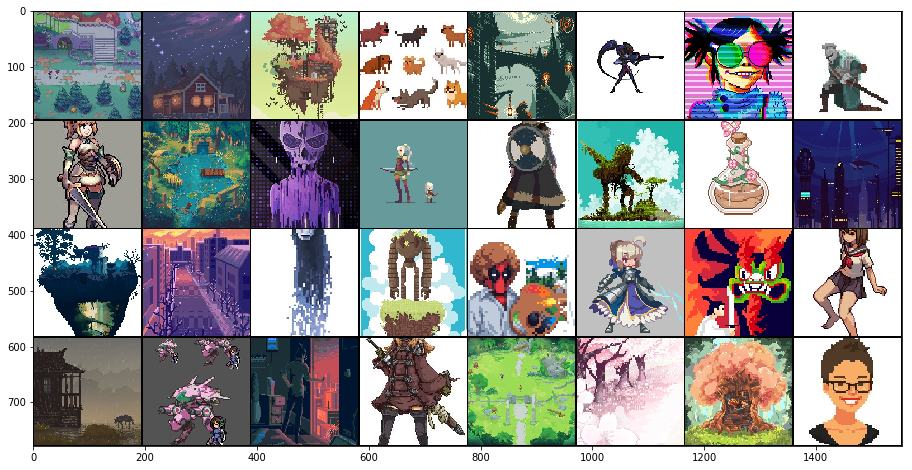

In [11]:
# get some images
images, labels = dataiter.next()
print(images.shape)

# show images
plt.figure(figsize=(18,8))
torchimshow(torchvision.utils.make_grid(images))
print(labels)

In [6]:
train_len = int(0.7*pixelDSlist.len)
valid_len = pixelDSlist.len - train_len
train, valid = D.random_split(pixelDSlist, lengths=[train_len, valid_len]) 
len(train), len(valid)

(541, 233)

Train: tensor([0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0,
        1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1,
        1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
        1, 1, 1, 1])
Valid: tensor([0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,
        1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1])


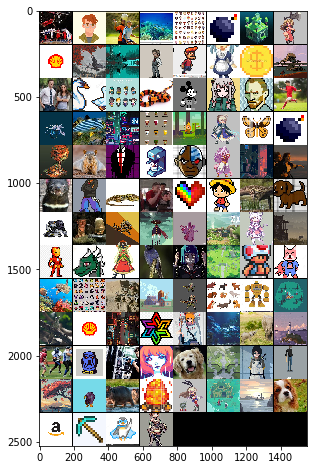

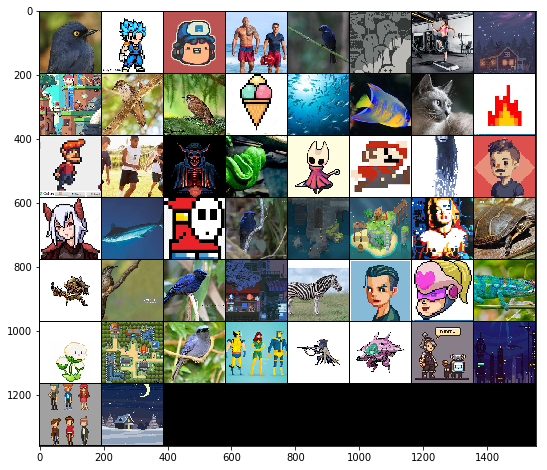

In [9]:
# Use the torch dataloader to iterate through the dataset
trainloader = D.DataLoader(train, batch_size=100, shuffle=False, num_workers=0)
validloader = D.DataLoader(valid, batch_size=50, shuffle=False, num_workers=0)

# get some images
dataiter_tr = iter(trainloader)
dataiter_vl = iter(validloader)
images_t, labels_t = dataiter_tr.next()
images_v, labels_v = dataiter_vl.next()

# show images
plt.figure(figsize=(16,8))
torchimshow(torchvision.utils.make_grid(images_t))
print('Train:',labels_t)
plt.figure(figsize=(16,8))
torchimshow(torchvision.utils.make_grid(images_v))
print('Valid:',labels_v)

In [24]:
dataiter_tr = iter(trainloader)
dataiter_vl = iter(validloader)

In [29]:
a=0
b=0
for j in range(0,10):
    dataiter_tr = iter(trainloader)
    dataiter_vl = iter(validloader)
    a+=1
    print(a)
    for i in range(0,5):
        images_t, labels_t = dataiter_tr.next()
        images_v, labels_v = dataiter_vl.next()
        b+=1
        print(b)
print(a,b)

1
1
2
3
4
5
2
6
7
8
9
10
3
11
12
13
14
15
4
16
17
18
19
20
5
21
22
23
24
25
6
26
27
28
29
30
7
31
32
33
34
35
8
36
37
38
39
40
9
41
42
43
44
45
10
46
47
48
49
50
10 50


In [14]:
filearray = []
labels = []
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
filenames = glob.glob(osp.join('images/Pixelart', '*.jpg'))
for fn in filenames:
    filearray.append(fn)
    labels.append(1)
# filenames = glob.glob(osp.join('images/Realpix/', '*.jpg'))
# for fn in filenames:
#     filearray.append(fn)
#     labels.append(0)
length = len(filearray)

imgarr = []
for index in range(0,length):
    image = Image.open(filearray[index])
    if image.size[0] != image.size[1]:
        sqrsize = min(image.size)
        croptrans = transforms.CenterCrop((sqrsize,sqrsize))
        image = croptrans(image)
    nimage = image.resize((192, 192), Image.NEAREST)
    nimage = nimage.convert('RGB')
    img = np.array(nimage)
    imgarr.append(img)
imgarr = np.array(imgarr)
imgarr = np.moveaxis(imgarr,3,1)
# t = transforms.ToTensor()
img = torch.from_numpy(imgarr).float().to(device)
print(imgarr.shape, img.shape, len(labels))

# np.save('picsle8_ImageArray_774RGB',imgarr)
# np.save('picsle8_LabelArray_774',labels)

(550, 3, 192, 192) torch.Size([550, 3, 192, 192]) 550


In [10]:
print(img[0])

tensor([[[115., 118., 120.,  ...,  87.,  86., 158.],
         [120., 118., 120.,  ..., 100.,  69., 169.],
         [121., 119., 121.,  ...,  87., 108., 160.],
         ...,
         [169., 148., 140.,  ...,  36.,  34.,  45.],
         [148., 149., 129.,  ...,  35.,  48.,  35.],
         [170., 136., 127.,  ...,  30.,  39.,  61.]],

        [[172., 175., 179.,  ..., 140., 108., 153.],
         [177., 176., 179.,  ..., 152.,  89., 163.],
         [178., 176., 179.,  ..., 134., 128., 154.],
         ...,
         [123.,  97.,  84.,  ...,  61.,  52.,  58.],
         [ 97.,  93.,  71.,  ...,  57.,  67.,  49.],
         [118.,  79.,  66.,  ...,  52.,  60.,  77.]],

        [[ 91., 106.,  99.,  ..., 154., 131., 185.],
         [ 96., 102.,  97.,  ..., 166., 114., 197.],
         [ 97.,  99.,  95.,  ..., 152., 155., 192.],
         ...,
         [126., 106.,  97.,  ...,  92.,  90., 103.],
         [102., 102.,  85.,  ...,  96., 109.,  96.],
         [122.,  88.,  81.,  ...,  93., 103., 126.]]]

In [26]:
npzimg = np.load('picsle8_ImageArray_774RGB.npy')
npzlbl = np.load('picsle8_LabelArray_774.npy')

print(npzimg.shape, npzlbl.shape)

(774, 192, 192, 3) (774,)


# Color Histogram Comparison

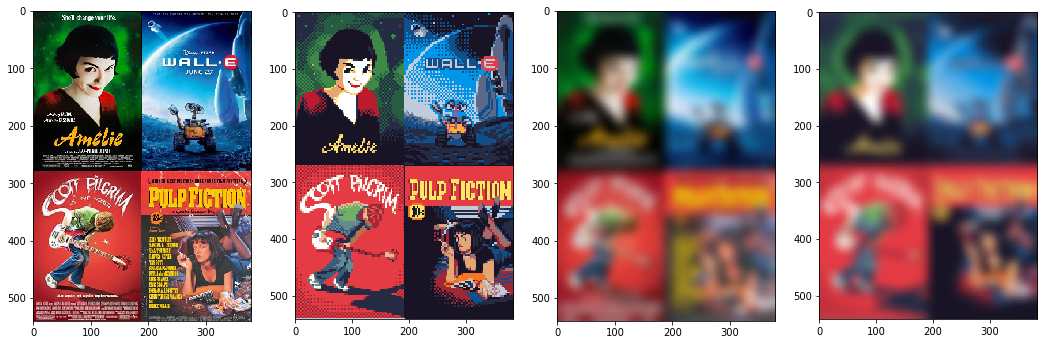

In [20]:
# import the necessary packages
from matplotlib import pyplot as plt
import numpy as np
import cv2

 
# load the image and show it
image_r = cv2.cvtColor(cv2.imread('images/posters_real.png'), cv2.COLOR_BGR2RGB)
image_p = cv2.cvtColor(cv2.imread('images/posters_pix.png'), cv2.COLOR_BGR2RGB)
# similar size
image_r = cv2.resize(image_r, dsize=(380, 540), interpolation=cv2.INTER_NEAREST)

gblur_p = cv2.GaussianBlur(image_p,(35,35),9)
gblur_r = cv2.GaussianBlur(image_r,(35,35),9)

imgarr = []
imgarr.append(image_r)
imgarr.append(image_p)
imgarr.append(gblur_r)
imgarr.append(gblur_p)
displayimage(imgarr,r=1,c=4)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(256, 1) (256, 1)


(0, 256)

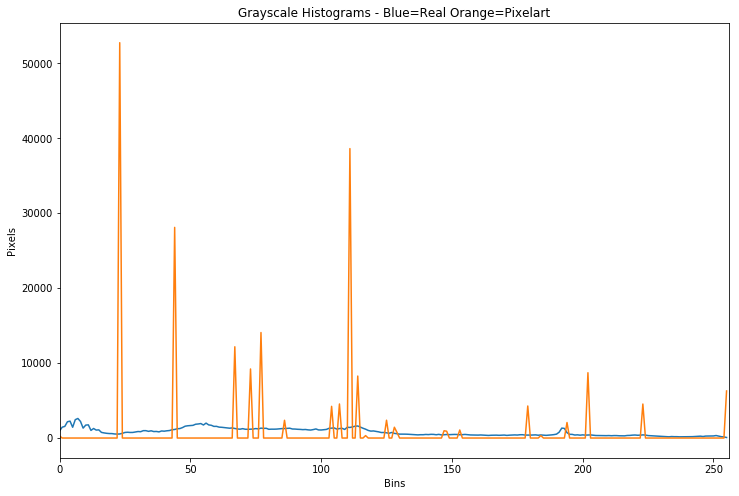

In [21]:
# convert the image to grayscale and create a histogram
grayr = cv2.cvtColor(image_r, cv2.COLOR_RGB2GRAY)
grayp = cv2.cvtColor(image_p, cv2.COLOR_RGB2GRAY)

histr = cv2.calcHist([grayr], [0], None, [256], [0, 256])
histp = cv2.calcHist([grayp], [0], None, [256], [0, 256])
print(type(histr),type(histp))
print(histr.shape, histp.shape)
plt.figure(figsize=(12,8))
plt.title("Grayscale Histograms - Blue=Real Orange=Pixelart")
plt.xlabel("Bins")
plt.ylabel("Pixels")
plt.plot(histr)
plt.plot(histp)
plt.xlim([0, 256])

(0, 256)

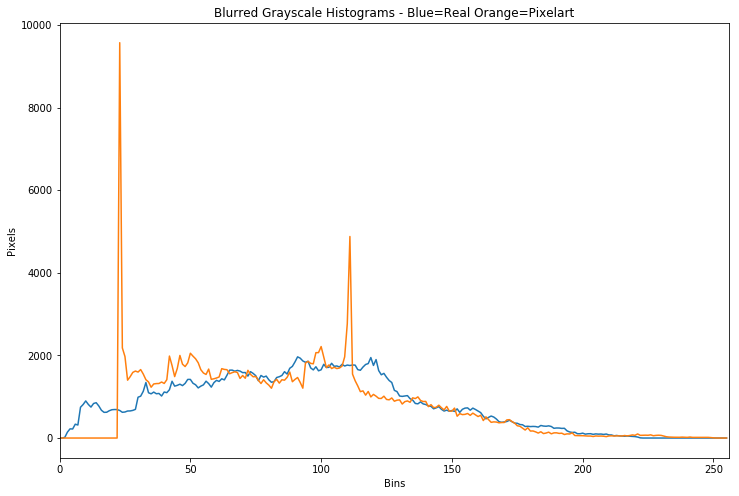

In [22]:
# convert the image to grayscale and create a histogram
grayr = cv2.cvtColor(gblur_r, cv2.COLOR_RGB2GRAY)
grayp = cv2.cvtColor(gblur_p, cv2.COLOR_RGB2GRAY)

histr = cv2.calcHist([grayr], [0], None, [256], [0, 256])
histp = cv2.calcHist([grayp], [0], None, [256], [0, 256])
plt.figure(figsize=(12,8))
plt.title("Blurred Grayscale Histograms - Blue=Real Orange=Pixelart")
plt.xlabel("Bins")
plt.ylabel("Pixels")
plt.plot(histr)
plt.plot(histp)
plt.xlim([0, 256])

<class 'numpy.ndarray'>
(256, 1)


(0, 256)

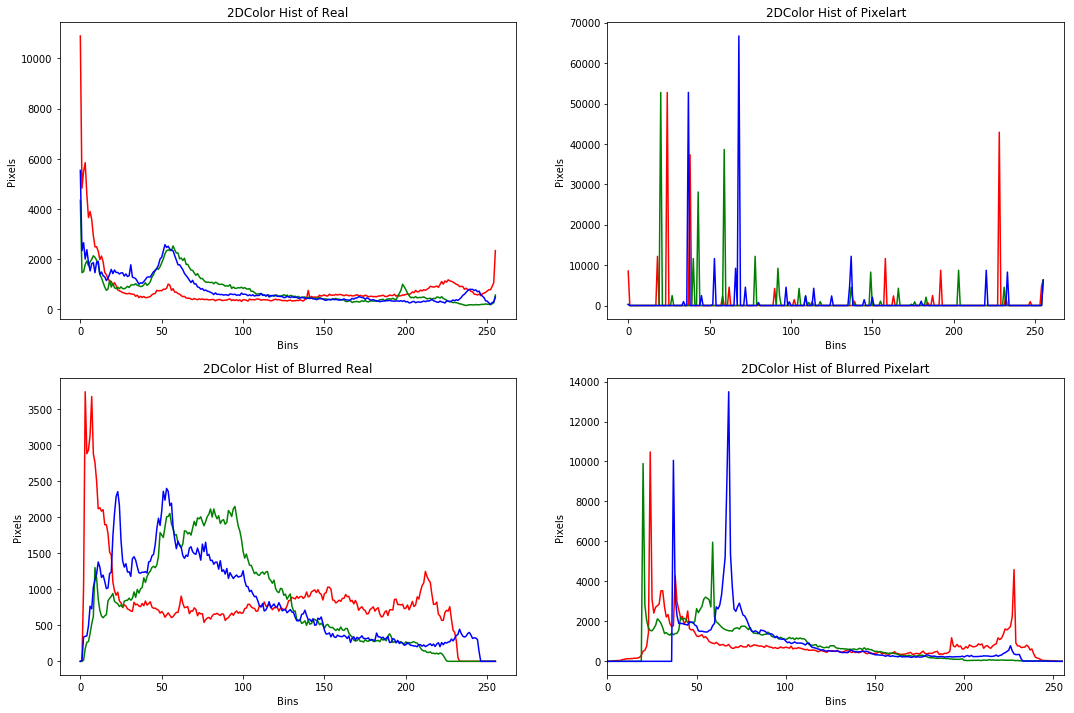

In [23]:
## grab the image channels, initialize the tuple of colors,
# the figure and the flattened feature vector
colors = ('r','g','b')
plt.figure(figsize=(18,12))

chans = cv2.split(image_r)
plt.subplot(2,2,1)
plt.title("2DColor Hist of Real")
plt.xlabel("Bins")
plt.ylabel("Pixels")
features = []
# loop over the image channels
for (chan, color) in zip(chans, colors):
    # create a histogram for the current channel and
    # concatenate the resulting histograms for each
    # channel
    hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
    features.extend(hist)
    # plot the histogram
    plt.plot(hist, color = color)
    #plt.xlim([0, 256])
    
    
chans = cv2.split(image_p)
plt.subplot(2,2,2)
plt.title("2DColor Hist of Pixelart")
plt.xlabel("Bins")
plt.ylabel("Pixels")
features = []
# loop over the image channels
for (chan, color) in zip(chans, colors):
    # create a histogram for the current channel and
    # concatenate the resulting histograms for each
    # channel
    hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
    features.extend(hist)
    # plot the histogram
    plt.plot(hist, color = color)

    
chans = cv2.split(gblur_r)
plt.subplot(2,2,3)
plt.title("2DColor Hist of Blurred Real")
plt.xlabel("Bins")
plt.ylabel("Pixels")
features = []
# loop over the image channels
for (chan, color) in zip(chans, colors):
    # create a histogram for the current channel and
    # concatenate the resulting histograms for each
    # channel
    hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
    features.extend(hist)
    # plot the histogram
    plt.plot(hist, color = color)
    
    
chans = cv2.split(gblur_p)
plt.subplot(2,2,4)
plt.title("2DColor Hist of Blurred Pixelart")
plt.xlabel("Bins")
plt.ylabel("Pixels")
features = []
# loop over the image channels
for (chan, color) in zip(chans, colors):
    # create a histogram for the current channel and
    # concatenate the resulting histograms for each
    # channel
    hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
    features.extend(hist)
    # plot the histogram
    plt.plot(hist, color = color)
    
plt.xlim([0, 256])



# print ("flattened feature vector size: %d" % (np.array(features).flatten().shape))

In [33]:
imgarr = np.load('picsle8_ImageArray_RealpixFlickr_500.npy')
imgarrcanny = np.load('picsle8_ImageArray_CannyRealpixFlickr_500.npy')
i=0

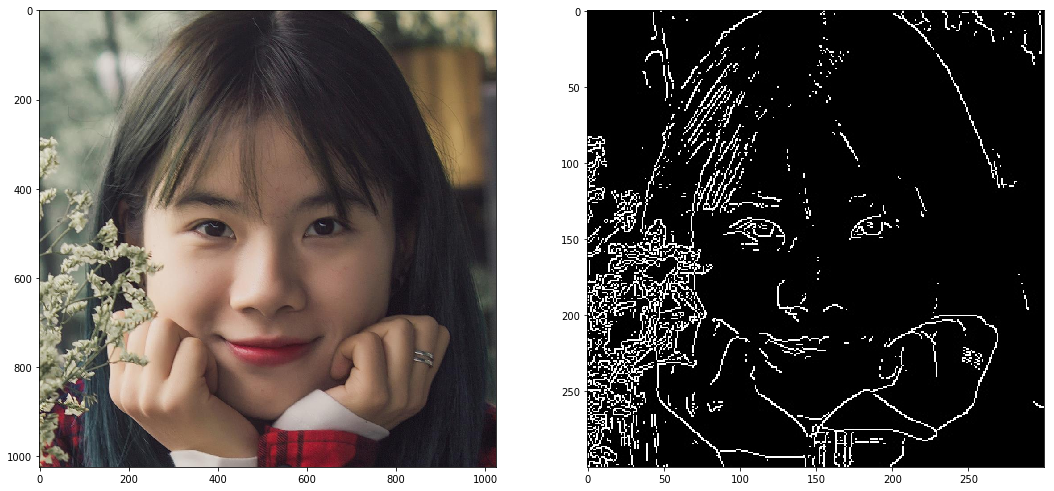

In [116]:
plotarr = []

plotarr.append(imgarr[i])
plotarr.append(imgarrcanny[i])
i+=1
displayimage(imgarr=plotarr,c=2,r=1)